In [1]:
import torch
import torchvision
import torchvision.transforms as transform
import PIL
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
import cv2
%matplotlib inline


In [2]:
import os
import sys
import shutil
import tempfile

from urllib.request import urlretrieve

# Data directory. Change this to download to a different directory, e.g. to an external drive to save space. 
# You need 20 GB to store all data.
# If you use Google Colab to run this notebook, then you may want to point this to a Google Drive directory shared
# between you and your assignment partner.
dir_data = os.path.abspath("D:/Academics/TUe_Modules/Avular/AED/Datasets/Cityscapes")

# URLs to retrieve ground truth and images data from. 
url_truth = 'https://flux127120.nbw.tue.nl/index.php/s/Cwxa5Ft2pQBK9N7/download'
dir_truth = os.path.join(dir_data, "gtFine")

url_input = 'https://flux127120.nbw.tue.nl/index.php/s/Tz3GCjQwwsiHgqC/download'
dir_input = os.path.join(dir_data, "leftImg8bit")

# Download and extraction function
def download_extract(url: str):
    # Create a temp directory to download into
    with tempfile.TemporaryDirectory(dir=dir_data, prefix="download_") as dir_temp:
        print(f'Downloading: {url}')
        zip_path = os.path.join(dir_temp, 'download.zip')
        urlretrieve(url, zip_path, lambda n, size, total: sys.stdout.write(f'\rProgress: {n*size/total*100:.2f} %'))
        sys.stdout.write('\n')
        sys.stdout.flush()

        print(f'Unpacking archive.')
        shutil.unpack_archive(zip_path, dir_data)

# Create the data directory (if it does not exist)
os.makedirs(dir_data, exist_ok=True)

# Check if both the ground truth and input directories have been downloaded and extracted
for dir, url in [(dir_truth, url_truth), (dir_input, url_input)]:
    if not os.path.isdir(dir):
        # Download the required files
        print(f'Directory does not exist: {dir}')
        download_extract(url)
    else:
        print(f'Directory already downloaded: {dir}')

# Done!
print(f'All data downloaded')



Directory already downloaded: D:\Academics\TUe_Modules\Avular\AED\Datasets\Cityscapes\gtFine
Directory already downloaded: D:\Academics\TUe_Modules\Avular\AED\Datasets\Cityscapes\leftImg8bit
All data downloaded


The downloaded images are very large. A consumer-grade PC likely does not have enough GPU-memory or data bandwidth to create a viable implementation in the original size. For this reason, we run a pre-processing step on the dataset that downscales all images. Once you have a working model, you may consider using a larger `sample_size`.

In [3]:
from PIL import Image

# Target size of each sample in the dataset
sample_size = (512, 256)

# Directories for preprocessed datasets
dir_truth_pp, dir_input_pp = (f'{d}_{sample_size[0]}_{sample_size[1]}' for d in (dir_truth, dir_input))

# Run preprocessing
for dir_full, dir_pp in ((dir_truth, dir_truth_pp), (dir_input, dir_input_pp)):
    # Check if the directory already exists
    if os.path.isdir(dir_pp):
        print(f'Preprocessed directory already exists: {dir_pp}')
        continue

    print(f'Preprocessing: {dir_full}')

    # Walk though the directory and preprocess each file 
    for root,_,files in  os.walk( dir_full ):
        if len(files) == 0:
            continue

        print(f'Preprocessing sub-directory: {root.replace(dir_full, "")}')

        # Create the directory in the preprocessed set
        root_pp = root.replace(dir_full, dir_pp)
        os.makedirs(root_pp, exist_ok=True)

        for f in files:
            if not f.endswith('.png'):
                continue

            # Resize and save PNG image
            path_original = os.path.join(root,f)
            img_resized = Image.open(path_original).resize(sample_size, Image.NEAREST)
            img_resized.save(path_original.replace(dir_full, dir_pp), 'png', quality=100)

print(f'Preprocessing done')


Preprocessed directory already exists: D:\Academics\TUe_Modules\Avular\AED\Datasets\Cityscapes\gtFine_512_256
Preprocessed directory already exists: D:\Academics\TUe_Modules\Avular\AED\Datasets\Cityscapes\leftImg8bit_512_256
Preprocessing done


## Data structures

Now that our data has been downloaded, we can proceed to define some data structures to model the structure of the provided data. Each semantic class that we aim to detect has a unique name, id and color. For more information on the datset, view [this link](https://www.cityscapes-dataset.com/dataset-overview/). For this assigment we expect your model to output just for the classes used for evaluation.

In [13]:
from dataclasses import dataclass
from typing import Tuple
import re

# Each sample we downloaded can be identified by the name of the city as well as a frame and sequence id
@dataclass
class CityscapesSample:
    city: str
    seq_id: str
    frame_id: str

    @property
    def id(self):
        return os.path.join(self.city, "_".join([self.city, self.seq_id, self.frame_id]))

    @staticmethod
    def from_filename(filename: str):
        # Create a CityscapesSample from a filename, which has a fixed structure {city}_{sequence}_{frame}
        match = re.match(r"^(\w+)_(\d+)_(\d+).*.png$", filename, re.I)
        return CityscapesSample(match.group(1), match.group(2), match.group(3))


# Each class that we aim to detect is assigned a name, id and color.
@dataclass
class CityscapesClass:
    name: str       # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    ID: int         # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    trainId: int    # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    category: str   # The name of the category that this label belongs to

    categoryId: int # The ID of this category. Used to create ground truth images
                    # on category level.

    hasInstances: bool # Whether this label distinguishes between single instances or not

    ignoreInEval: bool # Whether pixels having this class as ground truth label are ignored
                       # during evaluations or not

    color: Tuple[int, int, int]       # The color of this label



# ]


# List of classes that we want to detect in the input
classes = [
    #                 name                     ID    trainId   category            catId     hasInstances   ignoreInEval   color
    CityscapesClass(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    CityscapesClass(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    CityscapesClass(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    CityscapesClass(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , True        , (244, 35,232) ),
    CityscapesClass(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    CityscapesClass(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    CityscapesClass(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , True        , ( 70, 70, 70) ),
    CityscapesClass(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , True        , (102,102,156) ),
    CityscapesClass(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , True        , (190,153,153) ),
    CityscapesClass(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    CityscapesClass(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    CityscapesClass(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    CityscapesClass(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , True        , (153,153,153) ),
    CityscapesClass(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (0  ,  0,  0) ),
    CityscapesClass(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , True        , (250,170, 30) ),
    CityscapesClass(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , True        , (220,220,  0) ),
    CityscapesClass(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , True        , (107,142, 35) ),
    CityscapesClass(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , True        , (152,251,152) ),
    CityscapesClass(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , True        , ( 70,130,180) ),
    CityscapesClass(  'person'               , 24 ,       11 , 'human'           , 6       , True         , True        , (220, 20, 60) ),
    CityscapesClass(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , True        , (255,  0,  0) ),
    CityscapesClass(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , True        , (  0,  0,142) ),
    CityscapesClass(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , True        , (  0,  0, 70) ),
    CityscapesClass(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , True       , (  0, 60,100) ),
    CityscapesClass(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    CityscapesClass(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    CityscapesClass(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , True        , (  0, 80,100) ),
    CityscapesClass(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , True        , (  0,  0,230) ),
    CityscapesClass(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , True        , (119, 11, 32) ),
    CityscapesClass(  'license plate'        , -1 ,      255 , 'vehicle'         , 7       , False        , True         , (0  ,0  ,  0) ),

]



class_name_to_id = {
    'road': 7,  # 'road' class ID is 7 in the provided class list
    # Add other class names and their corresponding IDs if needed
}



# def create_mask(m):
#     mask = Image.open(m)
#     mask = transform.ToTensor()(mask).squeeze(0)  # Convert to PyTorch tensor

#     mask_binary = torch.zeros(2, mask.shape[1], mask.shape[2])  # Two channels for road and background

#     for i in range(34):
#         if i in classes['road']:
#             mask_binary[0] = mask_binary[0] + (mask == i).float()
#         elif i in classes['background']:
#             mask_binary[1] = mask_binary[1] + (mask == i).float()

#     mask_binary = torch.argmax(mask_binary, dim=0).byte()

#     mask_binary = mask_binary.numpy()
#     cv2.imwrite('Cityscapes/2_channel_mask/' + m.split('/')[-1], mask_binary)


In [ ]:
from glob import glob


mask_path = sorted(glob('D:/Academics/TUe_Modules/Avular/AED/Datasets/Cityscapes/gtFine_2048_1024/gtFine/train/')) 


# for i in tqdm(mask_path):
#     create_mask(i)

len(mask_path)

## Dataset implementation

This section implements a [PyTorch Dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). It transforms image and target colorization pairs from the downloaded files into pairs of input and ground truth tensors. The ground truths are single-channel images where the value of each pixel is equal to the ID of the class represented by the color in the target. This will enable us to train the network using cross-entropy. 

In [14]:
import numpy as np
import random
from torch.utils.data import Dataset
from PIL import Image
from typing import Dict, Optional, Tuple, List
from skimage.util import random_noise
from torchvision.transforms import GaussianBlur
import torchvision.transforms as TT
import albumentations as A                               

import torchvision.transforms.functional as TF
#import torchvision.transforms as transforms
from torchvision import transforms

class CityscapesDataset(Dataset):
    # Regular expression matching each PNG file in the dataset
    __read_reg = r"^(\w+)_(\d+)_(\d+).*.png$"

    def __init__(self, dir_input: str, dir_truth: str, sample_size: Tuple[int,int], classes: List[CityscapesSample]):
        super().__init__()

        # These variables are also available as globals, but it is good practice to make classes
        # not depend on global variables.
        self.dir_input = dir_input
        self.dir_truth = dir_truth
        self.sample_size = sample_size
        self.classes = classes

        # Walk through the inputs directory and add each file to our items list
        self.items = []
        for (_, _, filenames) in os.walk(self.dir_input):
            self.items.extend([CityscapesSample.from_filename(f) for f in filenames])

        # Sanity check: do the provided directories contain any samples?
        assert len(self.items) > 0, f"No items found in {self.dir_input}"

    def __len__(self):
        return len(self.items)

    def __getitem__(self, i: int) -> (torch.Tensor, torch.Tensor):
        sample = self.items[i]

        input = self.load_input(sample)
        truth = self.load_truth(sample)

        return self.transform(input, truth)

    def load_input(self, sample: CityscapesSample) -> Image:
        path = os.path.join(self.dir_input, f'{sample.id}_leftImg8bit.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def load_truth(self, sample:CityscapesSample) -> Image:
        path = os.path.join(self.dir_truth, f'{sample.id}_gtFine_color.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def transform(self, img: Image.Image, mask: Optional[Image.Image]) -> (torch.Tensor, torch.Tensor):
        ## EXERCISE #####################################################################
        #
        # Data augmentation is a way to improve the accuracy of a model.
        #
        # Once you have a model that works, you can implement some data augmentation 
        # techniques here to further improve performance.
        #
        ##################################################################################
         # Apply data augmentation to the copy
        
        # Apply Gaussian blur
        # if random.random() > 0.5:
        #     img = GaussianBlur(kernel_size=3, sigma=random.randint(1, 5))(img)

        # # Apply brightness
        # if random.random() > 0.5:
        #     img = TT.ColorJitter(brightness=2)(img)
           
        # if random.random() > 0.5:
        #     img = transform.Resize(size=self.sample_size)(img)
        #     if mask is not None:
        #         mask = transform.Resize(size=self.sample_size, interpolation=Image.NEAREST)(mask)
        
        img = TF.to_tensor(img)

        # Add noise to the image
        # if random.random() > 0.5:
        #    img = img + torch.randn(img.size()) * 0.03

        # if random.random() > 0.5:
        #     img = torch.tensor(random_noise(img, mode='gaussian', mean=0, var=0.05, clip=True))

        ################################################################################# 


        # If no mask is provided, then return only the image
        if mask is None:
            return img, None

        # Transform the mask from an image with RGB-colors to an 1-channel image with the index of the class as value
       
       
        mask_size = [s for s in self.sample_size]
        mask = torch.from_numpy(np.array(mask)).permute((2, 0, 1))
        target = torch.zeros((mask_size[1], mask_size[0]), dtype=torch.uint8)

        # Only process the "road" class
        road_class_id = class_name_to_id['road']
        eq = mask[0].eq(road_class_id) & mask[1].eq(road_class_id) & mask[2].eq(road_class_id)
        target[eq] = road_class_id

        return img, target
       
       
        # mask_size = [s for s in self.sample_size]
        # mask = torch.from_numpy(np.array(mask)).permute((2,0,1))
        # target = torch.zeros((mask_size[1], mask_size[0]), dtype=torch.uint8)
        # for i,c in enumerate(classes):
        #     eq = mask[0].eq(c.color[0]) & mask[1].eq(c.color[1]) & mask[2].eq(c.color[2])
        #     target[eq] = c.trainId    
            
        # return img, target

    def masks_to_indices(self, masks: torch.Tensor) -> torch.Tensor:
        _, indices = masks.softmax(dim=1).max(dim=1)
        return indices

    def to_image(self, indices: torch.Tensor) -> Image.Image:
        target = torch.zeros((3, indices.shape[0], indices.shape[1]),
                             dtype=torch.uint8, device=indices.device, requires_grad=False)

        for i, lbl in enumerate(self.classes):
            eq = indices.eq(lbl.trainId)

            target[0][eq] = lbl.color[0]
            target[1][eq] = lbl.color[1]
            target[2][eq] = lbl.color[2]

        return TF.to_pil_image(target.cpu(), 'RGB')

# Create one instance of the CityscapesDataset for each split type
ds_split = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes)
    for name in ("train", "val", "test")
}

# transform = transforms.Compose([
#             transforms.Resize(size=self.sample_size),
#             transforms.RandomHorizontalFlip(),
#             transforms.RandomRotation(degrees=10),
#             transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#             transforms.GaussianBlur(kernel_size=3),          
#             transforms.ToTensor(),
#         ])

The Cityscapes dataset is split in three parts: `train`, `val` and `test`. If everything is set-up correctly, we should be able to draw a random sample from each split, convert it back to an image, and display it.

Subset,Amount,Size,Input sample,Truth sample
train,2975,512×256,,
val,500,512×256,,
test,1525,512×256,,

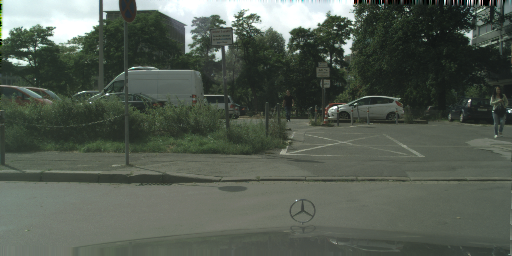
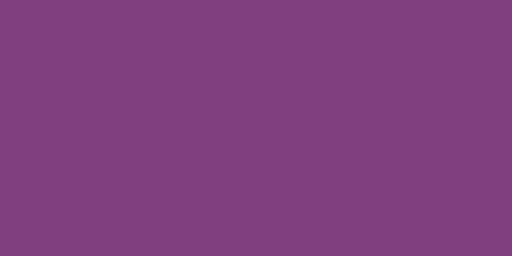
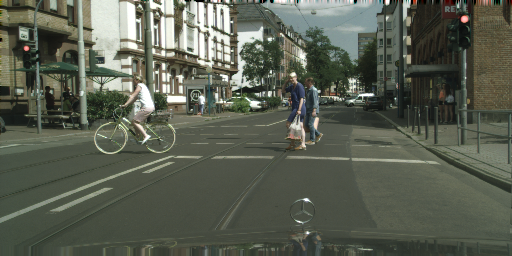
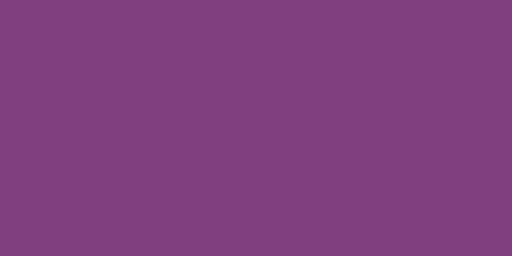
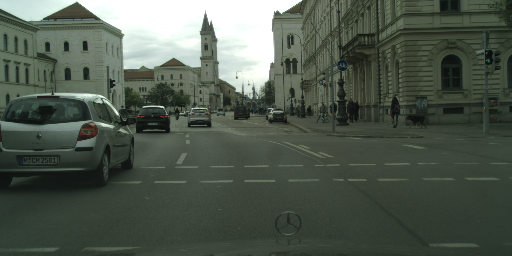
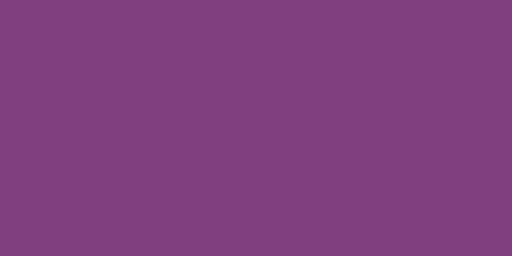

In [16]:
from IPython.display import display, HTML
from io import BytesIO
from base64 import b64encode

import random

# HTML templates for displaying random samples in a table
template_table = '<table><thead><tr><th>Subset</th><th>Amount</th><th>Size</th><th>Input sample</th><th>Truth sample</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td>{2}</td><td>{3}</td><td>{4}</td></tr>'
template_img = '<img src="data:image/png;base64,{0}"/>'

# Display a random sample of each split of the dataset
rows = []
for name, ds_sub in ds_split.items():
    # Draw a random sample from the dataset so that we can convert it back to an image
    input, truth = random.choice(ds_sub)
    #print(torch.unique(truth))

    input = TF.to_pil_image(input)
    truth = ds_sub.to_image(truth)

    # Create a buffer to save each retrieved image into such that we can base64-encode it for diplay in our HTML table
    with BytesIO() as buffer_input, BytesIO() as buffer_truth:
        input.save(buffer_input, format='png')
        truth.save(buffer_truth, format='png')

        # Store one row of the dataset
        images = [template_img.format(b64encode(b.getvalue()).decode('utf-8')) for b in (buffer_input, buffer_truth)]
        rows.append(template_row.format(name, len(ds_sub), '&times;'.join([str(s) for s in input.size]), *images))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))


In [ ]:
print(type(input))

Notice that the `test` set has no ground truth labels, as this is the set used to score competitors' networks against each other. If you submit the best network that you have created to the Cityscapes competition, this is the set that is used to calculate your score.

## Calculating accuracy
Your score on the benchmark will be calculated according to the the intersection-over-union (IoU) metric. [This link](https://www.cityscapes-dataset.com/benchmarks/#scene-labeling-task) describes how it is implemented in the testing suite. 

The function below is thus a measure for the accuracy of your solution. The `output` parameter represents the output of your network: a batch of multi-dimensional images with one channel per class. For every pixel, the class ID can be calculated by taking the index of the channel containing the maximum value. The `truths` parameter is a batch of ground truths from the `CityscapesDataset` defined above.

In [ ]:
def compute_iou(output: torch.Tensor, truths: torch.Tensor) -> float:
    output = output.detach().cpu()
    truths = truths.detach().cpu() ## EXERCISE #####################################################################
#
# Implement the IoU metric that is used by the benchmark to grade your results.
#     
# `output` is a tensor of dimensions [Batch, Classes, Height, Width]
# `truths` is a tensor of dimensions [Batch, Height, Width]
 #
 # Tip: Peform a sanity check that tests your implementation on a user-defined 
 #      tensor for which you know what the output should be.
 #
 #################################################################################     
    out = torch.argmax(output,1)
    tp, fp, fn = 0,0,0
    for i in range(1,34):
        outp = out == i
        tru = truths == i
        tp += torch.sum((outp == True) & (tru == True))
        fp += torch.sum((outp == True) & (tru == False))
        fn += torch.sum((outp == False) & (tru == True))
    iou = tp/(tp+fp+fn)
#################################################################################     
    return iou.item()

In [ ]:
from torch import nn, optim
from torch.utils.data import DataLoader


class Trainer:
    def __init__(self, model: nn.Module, ds_split: Dict[str,CityscapesDataset]):
        # Choose a device to run training on. Ideally, you have a GPU available to accelerate the training process.
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Move the model onto the target device
        self.model = model.to(self.device)

        # Store the dataset split
        self.ds_split = ds_split

        ## EXERCISE #####################################################################
        #
        # Select an optimizer
        self.optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
        # See: https://pytorch.org/docs/stable/optim.html
        #
        #self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = self.optimizer, mode='min', factor=0.5,min_lr = 1e-5)
        #self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        ################################################################################# 

       # self.optimizer = None

        ## EXERCISE #####################################################################
        #
        # Select an appropriate loss function
        #
        # See: https://pytorch.org/docs/stable/nn.html#loss-functions
        #
        ################################################################################# 
        self.critereon = nn.CrossEntropyLoss(ignore_index=255)
        #self.critereon = None

        ################################################################################# 

        assert self.critereon is not None, "You have not defined a loss"
        assert self.optimizer is not None, "You have not defined an optimizer"

    def train_epoch(self, dl:DataLoader):
        # Put the model in training mode
        self.model.train()

        # Store each step's accuracy and loss for this epoch
        epoch_metrics = {
            "loss": [],
            "accuracy": []
        }

        # Create a progress bar using TQDM
        sys.stdout.flush()
        with tqdm(total=len(self.ds_split["train"]), desc=f'Training') as pbar:
            # Iterate over the training dataset
            for inputs, truths in dl:
                # Zero the gradients from the previous step
                self.optimizer.zero_grad()

                # Move the inputs and truths to the target device
                inputs = inputs.to(device=self.device, dtype=torch.float32)
                inputs.required_grad = True  # Fix for older PyTorch versions
                truths = truths.to(device=self.device, dtype=torch.long)

                # Run model on the inputs
                output = self.model(inputs)

                # Perform backpropagation
                loss = self.critereon(output, truths)
                loss.backward()
                nn.utils.clip_grad_value_(model.parameters(), 0.1)
                self.optimizer.step()

                # Store the metrics of this step
                step_metrics = {
                    'loss': loss.item(),
                    'accuracy': compute_iou(output, truths)
                }

                # Update the progress bar
                pbar.set_postfix(**step_metrics)
                pbar.update(list(inputs.shape)[0])

                # Add to epoch's metrics
                for k,v in step_metrics.items():
                    epoch_metrics[k].append(v)

        sys.stdout.flush()

        # Return metrics
        return epoch_metrics

    def val_epoch(self, dl:DataLoader):
        # Put the model in evaluation mode
        self.model.eval()

        # Store the total loss and accuracy over the epoch
        amount = 0
        total_loss = 0
        total_accuracy = 0

        # Create a progress bar using TQDM
        sys.stdout.flush()
        with torch.no_grad(), tqdm(total=len(self.ds_split["val"]), desc=f'Validation') as pbar:
            # Iterate over the validation dataloader
            for inputs, truths in dl:
                 # Move the inputs and truths to the target device
                inputs = inputs.to(device=self.device, dtype=torch.float32)
                inputs.required_grad = True  # Fix for older PyTorch versions
                truths = truths.to(device=self.device, dtype=torch.long)

                # Run model on the inputs
                output = self.model(inputs)
                loss = self.critereon(output, truths)

                # Store the metrics of this step
                step_metrics = {
                    'loss': loss.item(),
                    'accuracy': compute_iou(output, truths)
                }

                # Update the progress bar
                pbar.set_postfix(**step_metrics)
                pbar.update(list(inputs.shape)[0])

                amount += 1
                total_loss += step_metrics["loss"]
            
                total_accuracy += step_metrics["accuracy"]
        sys.stdout.flush()

        # Print mean of metrics
        total_loss /= amount
        #self.scheduler.step(total_loss)
        total_accuracy /= amount
        print(f'Validation loss is {total_loss/amount}, validation accuracy is {total_accuracy}')

        # Return mean loss and accuracy
        return {
            "loss": [total_loss],
            "accuracy": [total_accuracy]
        }


    def fit(self, epochs: int, batch_size:int):
        # Initialize Dataloaders for the `train` and `val` splits of the dataset. 
        # A Dataloader loads a batch of samples from the each dataset split and concatenates these samples into a batch.
        dl_train = DataLoader(ds_split["train"], batch_size=batch_size, shuffle=True)
        dl_val = DataLoader(ds_split["val"], batch_size=batch_size, drop_last=True)

        # Store metrics of the training process (plot this to gain insight)
        df_train = pd.DataFrame()
        df_val = pd.DataFrame()

        # Train the model for the provided amount of epochs
        for epoch in range(1, epochs+1):
            print(f'Epoch {epoch}')
            metrics_train = self.train_epoch(dl_train)
            df_train = df_train.append(pd.DataFrame({'epoch': [epoch for _ in range(len(metrics_train["loss"]))], **metrics_train}), ignore_index=True)

            metrics_val = self.val_epoch(dl_val)
            df_val = df_val.append(pd.DataFrame({'epoch': [epoch], **metrics_val}), ignore_index=True)

        # Return a dataframe that logs the training process. This can be exported to a CSV or plotted directly.
        return df_train, df_val


Model Training

In [7]:
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader

c:\Users\bhara\miniconda3\envs\experiments_torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['road']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# @PipelineDecorator.component(return_values=['Training'])
aux_params=dict(
    pooling='avg',             # one of 'avg', 'max'
    dropout=0.5,               # dropout ratio, default is None
    activation=ACTIVATION,      # activation function, default is None
    classes=len(CLASSES),
                                   # define number of output labels
)

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
    # aux_params=aux_params
    
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [9]:
dl_train = DataLoader(ds_split["train"], batch_size=4, shuffle=True)
dl_val = DataLoader(ds_split["val"], batch_size=4, drop_last=True)

In [10]:
from segmentation_models_pytorch import utils

# loss = smp.utils.losses.DiceLoss()

loss = smp.losses.DiceLoss(mode='binary', from_logits=True)
loss.__name__ = 'Dice_loss'
# loss = smp.losses.TverskyLoss(mode = 'binary')   
# loss.__name__ = 'Twersky_Loss'

# loss = smp.losses.LovaszLoss(mode = 'binary')   
# loss.__name__ = 'Lovasz_Loss'

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
    # torch.optim.SGD( dict(params=model.parameters(), lr=0.1,momentum=0.9,weight_decay=0.0005))
])


In [11]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [12]:
max_score = 0

# logger = task.get_logger()
for i in range(0, 50):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(dl_train)
    valid_logs = valid_epoch.run(dl_val)
    print(train_logs)

    # logger.report_scalar('Dice_Loss train', 'model_output', iteration=i, value=train_logs['dice_loss'])
    # logger.report_scalar('IoU score train', 'model_output', iteration=i, value=train_logs['iou_score'])
    # logger.report_scalar('Dice_Loss valid', 'model_output', iteration=i, value=valid_logs['dice_loss'])
    # logger.report_scalar('IoU score valid', 'model_output', iteration=i, value=valid_logs['iou_score'])
    
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './cityscapes.pth')
        print('Model saved!')
        


Epoch: 0
train:  19%|█▉        | 144/744 [01:11<04:58,  2.01it/s, Dice_loss - -0.3452, iou_score - -1.432]


KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#To save the trained model
torch.save(model.state_dict(),'D:/Academics/TUe Modules/CNN_for_CV/Practice/model.pth')

In [ ]:
#to check
#model =  Model()
#model.load_state_dict(torch.load('D:/Academics/TUe Modules/CNN_for_CV/Practice/model.pth'))
